In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
cd '/content/drive/My Drive/semeval'

/content/drive/My Drive/semeval


In [0]:
import nltk

In [30]:
nltk.download(['stopwords','punkt','wordnet','averaged_perceptron_tagger'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
from sklearn.model_selection import train_test_split as split
import numpy as np

import numpy as np
import csv
from tqdm import tqdm
from sklearn.utils import shuffle

import copy
import imp

from gensim.models import Word2Vec,FastText,KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim.downloader as api
from os import listdir


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support



# class DataReader

In [0]:
class DataReader:

    def __init__(self,file_path):
        self.file_path = file_path
        
    def get_labelled_data(self):
        data = []
        labels = []
        with open(self.file_path,encoding='utf8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            for i,line in enumerate(tqdm(reader,'Reading Data')):
                if i is 0:
                    continue
                label = self.str_to_label(line[-3:])
                self.filter_subtask(data,labels,line[1],label)

        return data,labels
      
    def str_to_label(self,all_labels):
        label = 0
        if all_labels[0] == 'OFF':
           label = 1
        return label  
      
    def filter_subtask(self,data,labels,sample,label):
        data.append(sample)
        labels.append(int(label>0))   
    
    def shuffle(self,data,labels,state=None):
        if state == 'random':
            shuffled_data, shuffled_labels = shuffle(data, labels, random_state=7)
            return shuffled_data,shuffled_labels
        else:
            return data,labels

# class Preprocessor

In [0]:
class Preprocessor:

    def __init__(self,*args):
        self.params =[]
        if args:
            if isinstance(args[0],tuple):
                self.params = list(*args)
            else:
                self.params = list(args)
        self.params = ['tokenize']+self.params


    def clean(self, data):
        self.data = copy.deepcopy(data)
        for param in tqdm(self.params,'Preprocessing'):
            clean_call = getattr(self, param,None)
            print(clean_call)
            clean_call()
        return self.data    
      
    def tokenize(self):
        from nltk import word_tokenize
        for i,tweet in tqdm(enumerate(self.data),'Tokenization'):
            self.data[i] = word_tokenize(tweet.lower())
        return self.data 
      
    def remove_stopwords(self):
        from nltk.corpus import stopwords
        import re
        stop = set(stopwords.words("english"))
        noise = ['user']
        for i,tweet in tqdm(enumerate(self.data),'Stopwords Removal'):
            self.data[i] = [w for w in tweet if w not in stop and not re.match(r"[^a-zA-Z\d\s]+", w) and w not in noise]
        return self.data
      
    def get_pos(self, word):
        from nltk import pos_tag
        from nltk.corpus import wordnet
        tag = pos_tag([word])[0][1]
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  
    
    def lemmatize(self):
        from nltk.stem import WordNetLemmatizer
        wnl = WordNetLemmatizer()
        for i, tweet in tqdm(enumerate(self.data),'Lemmatization'):
            for j, word in enumerate(tweet):
                self.data[i][j] = wnl.lemmatize(word, pos=self.get_pos(word))
        return self.data  
    
    

# class Vectorizer

In [0]:
class Vectorizer:
    
    def __init__(self,type,pre_trained=False,retrain=False,extend_training=False,params={}):
        self.type = type
        self.pre_trained = pre_trained
        self.params = params
        self.retrain = retrain
        self.extend_training = extend_training
        self.vectorizer = None
        self.max_len = None
        
    def vectorize(self,data):
        self.data = data
        vectorize_call = getattr(self, self.type, None)
        vectorize_call()       
        return self.vectors   
      
    def count(self):
        vectorizer = CountVectorizer(**self.params)
        untokenized_data =[' '.join(tweet) for tweet in self.data]
        if not self.vectorizer:
            self.vectorizer = vectorizer.fit(untokenized_data)
        self.vectors = self.vectorizer.transform(untokenized_data).toarray()
        self.vocab_length = len(self.vectorizer.vocabulary_.keys())
        return self.vectors 
      
    def fit(self,data):
        self.data = data      

# class Classifier

In [0]:
class Classifier:
    
    def __init__(self,type,params={}):
        __classifers__ = {
        'LogisticRegression': LogisticRegression,
        'KNN': KNeighborsClassifier,
        'SVC': SVC,
        'DecisionTree': DecisionTreeClassifier,
        'RandomForest': RandomForestClassifier
        }
        self.classifier = __classifers__[type]
        self.params = params
        self.model = self.classifier(**self.params)   

    def fit(self,tr_data,tr_labels):
        return self.model.fit(tr_data,tr_labels)

    def predict(self,tst_data):
        return self.model.predict(tst_data)

    def score(self,tst_data,tst_labels):
        return self.model.score(tst_data,tst_labels)

    def tune(self,tr_data,tr_labels,tune_params=None,best_only=False):
        if not tune_params:
            tune_params = self.params
        tuner = GridSearchCV(self.model,tune_params,n_jobs=4,verbose=1)
        tuner.fit(tr_data,tr_labels)
        self.model = tuner.best_estimator_
        if best_only:
            return {'score':tuner.best_score_,'parmas':tuner.best_params_}
        else:
            param_scores = {}
            results = tuner.cv_results_
            for i,param in enumerate(tuner.cv_results_['params']):
                param_str  = ', '.join("{!s}={!r}".format(key,val) for (key,val) in param.items())
                param_scores[param_str]={'test_score':results['mean_test_score'][i],'train_score':results['mean_train_score'][i]}
            return param_scores
    
    def get_model(self):
        if getattr(self,'model',None):
            return self.model
        else:
            raise Exception('Model has not been created yet.')

    def test_and_plot(self,tst_data,tst_labels,class_num=2):
        tst_data = np.array(tst_data)
        tst_labels = np.array(tst_labels).reshape(-1,1)
        predicted_tst_labels = self.model.predict(tst_data)
        conf = np.zeros([class_num,class_num])
        confnorm = np.zeros([class_num,class_num])
        for i in range(0,tst_data.shape[0]):
            j = tst_labels[i,:]
            k = predicted_tst_labels[i]
            conf[j,k] = conf[j,k] + 1
        for i in range(0,class_num):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        self._confusion_matrix(confnorm, labels=[i for i in range(class_num)])
        return precision_recall_fscore_support(tst_labels, predicted_tst_labels, average='weighted')    

        #return self.model.score(tst_data,tst_labels)

    def _confusion_matrix(self,cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show() 
        
         
       
        

# Main

** 
  - read training data 
  - split training data into trainind and validation set **

In [36]:
dr = DataReader('./datasets/training-v1/offenseval-training-v1.tsv')
data,labels = dr.get_labelled_data()
data,labels = dr.shuffle(data,labels,'random')

tr_data,tst_data,tr_labels,tst_labels = split(data,labels,test_size=0.3)

Reading Data: 13241it [00:00, 192573.26it/s]


**
- preprocessors objects
- vectorizers
- classifiers

- note: Decesion tree as a benchmark
**

In [0]:
preprocessors = [('remove_stopwords','lemmatize'),('remove_stopwords','lemmatize'),('remove_stopwords','lemmatize'),('remove_stopwords','lemmatize'),('remove_stopwords','lemmatize')]
vectorizers = ['count','count','count','count','count']
classifiers = [('RandomForest',{'n_estimators':30}),
               ('LogisticRegression',{'penalty':'l2','solver':'sag'}),
              ('KNN',{'n_neighbors':5}),
              ('DecisionTree',{'criterion':'gini'}),
               ('SVC',{'C':10,'kernel':'rbf'})]



In [0]:
for i in range(len(vectorizers)):
  preprocessors[i] = Preprocessor(preprocessors[i])
  vectorizers[i] = Vectorizer(vectorizers[i])
  classifiers[i] = Classifier(*classifiers[i])

**
- preprocess
- vesualize
-train
**

In [39]:
tst_vecs = []
tr_vecs = []
for i in range(len(classifiers)):
  tr_data_clean = preprocessors[i].clean(tr_data)
  tr_vecs.append(vectorizers[i].vectorize(tr_data_clean))
  tst_data_clean = preprocessors[i].clean(tst_data)
  tst_vecs.append(vectorizers[i].vectorize(tst_data_clean))
  
  classifiers[i].fit(tr_vecs[i],tr_labels)



Preprocessing:   0%|          | 0/3 [00:00<?, ?it/s]
Tokenization: 0it [00:00, ?it/s]
Tokenization: 299it [00:00, 2987.14it/s]

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d21d0>>



Tokenization: 596it [00:00, 2980.15it/s]
Tokenization: 873it [00:00, 2912.70it/s]
Tokenization: 1185it [00:00, 2966.55it/s]
Tokenization: 1490it [00:00, 2990.06it/s]
Tokenization: 1773it [00:00, 2936.73it/s]
Tokenization: 2070it [00:00, 2945.63it/s]
Tokenization: 2371it [00:00, 2963.21it/s]
Tokenization: 2675it [00:00, 2985.63it/s]
Tokenization: 2976it [00:01, 2990.27it/s]
Tokenization: 3267it [00:01, 2928.73it/s]
Tokenization: 3555it [00:01, 2864.40it/s]
Tokenization: 3838it [00:01, 2790.04it/s]
Tokenization: 4115it [00:01, 2716.21it/s]
Tokenization: 4386it [00:01, 2688.98it/s]
Tokenization: 4655it [00:01, 2666.95it/s]
Tokenization: 4922it [00:01, 2624.53it/s]
Tokenization: 5190it [00:01, 2639.81it/s]
Tokenization: 5460it [00:01, 2656.12it/s]
Tokenization: 5737it [00:02, 2685.52it/s]
Tokenization: 6012it [00:02, 2704.20it/s]
Tokenization: 6321it [00:02, 2807.88it/s]
Tokenization: 6603it [00:02, 2793.69it/s]
Tokenization: 6884it [00:02, 2781.62it/s]
Tokenization: 7163it [00:02, 2757.9

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d21d0>>



Stopwords Removal: 8546it [00:00, 42746.46it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:03<00:02,  2.38s/it]
Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 52it [00:00, 512.96it/s]

<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d21d0>>



Lemmatization: 94it [00:00, 471.57it/s]
Lemmatization: 144it [00:00, 478.31it/s]
Lemmatization: 191it [00:00, 475.02it/s]
Lemmatization: 231it [00:00, 442.43it/s]
Lemmatization: 280it [00:00, 448.31it/s]
Lemmatization: 320it [00:00, 425.23it/s]
Lemmatization: 371it [00:00, 441.70it/s]
Lemmatization: 413it [00:00, 427.82it/s]
Lemmatization: 455it [00:01, 420.01it/s]
Lemmatization: 508it [00:01, 446.69it/s]
Lemmatization: 556it [00:01, 450.01it/s]
Lemmatization: 603it [00:01, 454.89it/s]
Lemmatization: 649it [00:01, 449.28it/s]
Lemmatization: 694it [00:01, 448.57it/s]
Lemmatization: 739it [00:01, 437.50it/s]
Lemmatization: 783it [00:01, 432.82it/s]
Lemmatization: 827it [00:01, 413.94it/s]
Lemmatization: 869it [00:01, 409.49it/s]
Lemmatization: 915it [00:02, 422.94it/s]
Lemmatization: 963it [00:02, 435.71it/s]
Lemmatization: 1010it [00:02, 444.64it/s]
Lemmatization: 1058it [00:02, 453.18it/s]
Lemmatization: 1115it [00:02, 482.26it/s]
Lemmatization: 1164it [00:02, 467.31it/s]
Lemmatizatio

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d21d0>>



Tokenization: 592it [00:00, 2984.70it/s]
Tokenization: 870it [00:00, 2919.67it/s]
Tokenization: 1138it [00:00, 2843.10it/s]
Tokenization: 1431it [00:00, 2868.12it/s]
Tokenization: 1740it [00:00, 2928.88it/s]
Tokenization: 2038it [00:00, 2938.42it/s]
Tokenization: 2323it [00:00, 2909.77it/s]
Tokenization: 2610it [00:00, 2897.37it/s]
Tokenization: 2889it [00:01, 2862.97it/s]
Tokenization: 3179it [00:01, 2873.83it/s]
Tokenization: 3475it [00:01, 2896.56it/s]
Tokenization: 3779it [00:01, 2937.47it/s]
Preprocessing:  33%|███▎      | 1/3 [00:01<00:02,  1.38s/it]
Stopwords Removal: 0it [00:00, ?it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:01<00:00,  1.00it/s]
Lemmatization: 0it [00:00, ?it/s]

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d21d0>>
<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d21d0>>



Lemmatization: 50it [00:00, 488.91it/s]
Lemmatization: 98it [00:00, 479.84it/s]
Lemmatization: 140it [00:00, 458.77it/s]
Lemmatization: 187it [00:00, 460.54it/s]
Lemmatization: 231it [00:00, 451.09it/s]
Lemmatization: 271it [00:00, 427.48it/s]
Lemmatization: 317it [00:00, 435.11it/s]
Lemmatization: 359it [00:00, 428.69it/s]
Lemmatization: 410it [00:00, 449.22it/s]
Lemmatization: 454it [00:01, 442.24it/s]
Lemmatization: 498it [00:01, 435.12it/s]
Lemmatization: 542it [00:01, 436.51it/s]
Lemmatization: 587it [00:01, 439.55it/s]
Lemmatization: 641it [00:01, 464.61it/s]
Lemmatization: 688it [00:01, 453.32it/s]
Lemmatization: 740it [00:01, 471.44it/s]
Lemmatization: 788it [00:01, 455.18it/s]
Lemmatization: 834it [00:01, 440.75it/s]
Lemmatization: 886it [00:01, 458.80it/s]
Lemmatization: 933it [00:02, 453.16it/s]
Lemmatization: 979it [00:02, 433.94it/s]
Lemmatization: 1023it [00:02, 421.82it/s]
Lemmatization: 1066it [00:02, 424.11it/s]
Lemmatization: 1109it [00:02, 418.04it/s]
Lemmatization:

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2780>>



Tokenization: 608it [00:00, 3067.57it/s]
Tokenization: 877it [00:00, 2942.13it/s]
Tokenization: 1180it [00:00, 2966.81it/s]
Tokenization: 1476it [00:00, 2964.47it/s]
Tokenization: 1755it [00:00, 2908.74it/s]
Tokenization: 2037it [00:00, 2878.15it/s]
Tokenization: 2331it [00:00, 2890.25it/s]
Tokenization: 2613it [00:00, 2867.16it/s]
Tokenization: 2896it [00:01, 2855.65it/s]
Tokenization: 3184it [00:01, 2860.24it/s]
Tokenization: 3465it [00:01, 2832.28it/s]
Tokenization: 3749it [00:01, 2833.45it/s]
Tokenization: 4030it [00:01, 2819.56it/s]
Tokenization: 4336it [00:01, 2885.25it/s]
Tokenization: 4630it [00:01, 2900.67it/s]
Tokenization: 4920it [00:01, 2870.80it/s]
Tokenization: 5234it [00:01, 2944.95it/s]
Tokenization: 5529it [00:01, 2922.16it/s]
Tokenization: 5822it [00:02, 2892.80it/s]
Tokenization: 6113it [00:02, 2897.92it/s]
Tokenization: 6426it [00:02, 2962.88it/s]
Tokenization: 6723it [00:02, 2906.26it/s]
Tokenization: 7015it [00:02, 2896.35it/s]
Tokenization: 7306it [00:02, 2872.4

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2780>>



Stopwords Removal: 8415it [00:00, 41404.36it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:03<00:02,  2.43s/it]
Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 49it [00:00, 472.42it/s]

<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2780>>



Lemmatization: 90it [00:00, 448.95it/s]
Lemmatization: 139it [00:00, 458.34it/s]
Lemmatization: 184it [00:00, 455.26it/s]
Lemmatization: 222it [00:00, 427.85it/s]
Lemmatization: 269it [00:00, 437.81it/s]
Lemmatization: 311it [00:00, 429.74it/s]
Lemmatization: 352it [00:00, 423.14it/s]
Lemmatization: 397it [00:00, 429.66it/s]
Lemmatization: 441it [00:01, 429.04it/s]
Lemmatization: 489it [00:01, 440.20it/s]
Lemmatization: 544it [00:01, 465.94it/s]
Lemmatization: 591it [00:01, 465.48it/s]
Lemmatization: 638it [00:01, 433.77it/s]
Lemmatization: 685it [00:01, 441.69it/s]
Lemmatization: 730it [00:01, 439.13it/s]
Lemmatization: 775it [00:01, 442.09it/s]
Lemmatization: 820it [00:01, 420.87it/s]
Lemmatization: 863it [00:01, 408.82it/s]
Lemmatization: 913it [00:02, 431.08it/s]
Lemmatization: 961it [00:02, 440.29it/s]
Lemmatization: 1009it [00:02, 449.83it/s]
Lemmatization: 1056it [00:02, 455.66it/s]
Lemmatization: 1107it [00:02, 469.53it/s]
Lemmatization: 1155it [00:02, 463.74it/s]
Lemmatizatio

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2780>>



Tokenization: 604it [00:00, 3041.25it/s]
Tokenization: 854it [00:00, 2853.87it/s]
Tokenization: 1129it [00:00, 2820.38it/s]
Tokenization: 1413it [00:00, 2823.30it/s]
Tokenization: 1731it [00:00, 2915.83it/s]
Tokenization: 2016it [00:00, 2894.60it/s]
Tokenization: 2314it [00:00, 2918.98it/s]
Tokenization: 2594it [00:00, 2881.61it/s]
Tokenization: 2879it [00:01, 2871.98it/s]
Tokenization: 3169it [00:01, 2878.16it/s]
Tokenization: 3468it [00:01, 2907.20it/s]
Tokenization: 3755it [00:01, 2885.84it/s]
Preprocessing:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]
Stopwords Removal: 0it [00:00, ?it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:01<00:01,  1.01s/it]
Lemmatization: 0it [00:00, ?it/s]

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2780>>
<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2780>>



Lemmatization: 51it [00:00, 499.63it/s]
Lemmatization: 98it [00:00, 486.95it/s]
Lemmatization: 145it [00:00, 478.42it/s]
Lemmatization: 190it [00:00, 464.12it/s]
Lemmatization: 236it [00:00, 460.83it/s]
Lemmatization: 277it [00:00, 439.16it/s]
Lemmatization: 320it [00:00, 435.80it/s]
Lemmatization: 360it [00:00, 416.33it/s]
Lemmatization: 410it [00:00, 437.90it/s]
Lemmatization: 453it [00:01, 434.56it/s]
Lemmatization: 496it [00:01, 429.87it/s]
Lemmatization: 539it [00:01, 427.64it/s]
Lemmatization: 593it [00:01, 455.89it/s]
Lemmatization: 646it [00:01, 473.83it/s]
Lemmatization: 694it [00:01, 461.79it/s]
Lemmatization: 746it [00:01, 477.36it/s]
Lemmatization: 795it [00:01, 445.51it/s]
Lemmatization: 841it [00:01, 438.90it/s]
Lemmatization: 893it [00:01, 460.04it/s]
Lemmatization: 940it [00:02, 448.67it/s]
Lemmatization: 986it [00:02, 435.60it/s]
Lemmatization: 1030it [00:02, 417.99it/s]
Lemmatization: 1073it [00:02, 421.29it/s]
Lemmatization: 1119it [00:02, 429.51it/s]
Lemmatization:

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2c50>>



Tokenization: 582it [00:00, 2908.19it/s]
Tokenization: 848it [00:00, 2827.45it/s]
Tokenization: 1146it [00:00, 2869.26it/s]
Tokenization: 1442it [00:00, 2895.74it/s]
Tokenization: 1724it [00:00, 2866.70it/s]
Tokenization: 2003it [00:00, 2840.69it/s]
Tokenization: 2282it [00:00, 2819.08it/s]
Tokenization: 2574it [00:00, 2847.13it/s]
Tokenization: 2861it [00:01, 2849.32it/s]
Tokenization: 3138it [00:01, 2799.60it/s]
Tokenization: 3413it [00:01, 2776.68it/s]
Tokenization: 3698it [00:01, 2790.99it/s]
Tokenization: 3978it [00:01, 2793.44it/s]
Tokenization: 4277it [00:01, 2848.09it/s]
Tokenization: 4566it [00:01, 2859.43it/s]
Tokenization: 4852it [00:01, 2805.50it/s]
Tokenization: 5151it [00:01, 2858.31it/s]
Tokenization: 5449it [00:01, 2892.37it/s]
Tokenization: 5739it [00:02, 2882.26it/s]
Tokenization: 6028it [00:02, 2843.77it/s]
Tokenization: 6339it [00:02, 2917.05it/s]
Tokenization: 6634it [00:02, 2926.08it/s]
Tokenization: 6928it [00:02, 2872.60it/s]
Tokenization: 7216it [00:02, 2869.2

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2c50>>



Stopwords Removal: 8377it [00:00, 41358.92it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:03<00:02,  2.36s/it]
Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 49it [00:00, 489.87it/s]

<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2c50>>



Lemmatization: 90it [00:00, 458.49it/s]
Lemmatization: 139it [00:00, 465.75it/s]
Lemmatization: 186it [00:00, 462.79it/s]
Lemmatization: 226it [00:00, 438.54it/s]
Lemmatization: 268it [00:00, 432.60it/s]
Lemmatization: 310it [00:00, 425.50it/s]
Lemmatization: 351it [00:00, 415.47it/s]
Lemmatization: 397it [00:00, 424.30it/s]
Lemmatization: 441it [00:01, 425.09it/s]
Lemmatization: 489it [00:01, 435.52it/s]
Lemmatization: 543it [00:01, 460.54it/s]
Lemmatization: 589it [00:01, 454.77it/s]
Lemmatization: 635it [00:01, 439.46it/s]
Lemmatization: 679it [00:01, 437.55it/s]
Lemmatization: 725it [00:01, 441.16it/s]
Lemmatization: 770it [00:01, 432.78it/s]
Lemmatization: 814it [00:01, 419.03it/s]
Lemmatization: 857it [00:01, 402.27it/s]
Lemmatization: 909it [00:02, 430.91it/s]
Lemmatization: 958it [00:02, 439.81it/s]
Lemmatization: 1004it [00:02, 445.30it/s]
Lemmatization: 1049it [00:02, 445.34it/s]
Lemmatization: 1102it [00:02, 462.82it/s]
Lemmatization: 1149it [00:02, 451.86it/s]
Lemmatizatio

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2c50>>



Tokenization: 582it [00:00, 2931.76it/s]
Tokenization: 864it [00:00, 2896.75it/s]
Tokenization: 1136it [00:00, 2839.34it/s]
Tokenization: 1423it [00:00, 2847.24it/s]
Tokenization: 1720it [00:00, 2882.47it/s]
Tokenization: 2023it [00:00, 2924.03it/s]
Tokenization: 2326it [00:00, 2955.00it/s]
Tokenization: 2612it [00:00, 2924.64it/s]
Tokenization: 2893it [00:01, 2875.80it/s]
Tokenization: 3182it [00:01, 2879.53it/s]
Tokenization: 3474it [00:01, 2890.60it/s]
Tokenization: 3778it [00:01, 2933.25it/s]
Preprocessing:  33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]
Stopwords Removal: 0it [00:00, ?it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:01<00:01,  1.00s/it]
Lemmatization: 0it [00:00, ?it/s]

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2c50>>
<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2c50>>



Lemmatization: 48it [00:00, 479.43it/s]
Lemmatization: 96it [00:00, 476.47it/s]
Lemmatization: 138it [00:00, 457.54it/s]
Lemmatization: 186it [00:00, 460.67it/s]
Lemmatization: 231it [00:00, 451.60it/s]
Lemmatization: 271it [00:00, 427.59it/s]
Lemmatization: 317it [00:00, 434.55it/s]
Lemmatization: 358it [00:00, 424.59it/s]
Lemmatization: 407it [00:00, 441.56it/s]
Lemmatization: 451it [00:01, 437.26it/s]
Lemmatization: 494it [00:01, 421.32it/s]
Lemmatization: 536it [00:01, 415.71it/s]
Lemmatization: 588it [00:01, 442.31it/s]
Lemmatization: 643it [00:01, 466.84it/s]
Lemmatization: 691it [00:01, 458.05it/s]
Lemmatization: 745it [00:01, 479.05it/s]
Lemmatization: 794it [00:01, 448.68it/s]
Lemmatization: 840it [00:01, 440.40it/s]
Lemmatization: 893it [00:01, 462.50it/s]
Lemmatization: 940it [00:02, 441.43it/s]
Lemmatization: 985it [00:02, 428.70it/s]
Lemmatization: 1029it [00:02, 410.73it/s]
Lemmatization: 1072it [00:02, 416.10it/s]
Lemmatization: 1119it [00:02, 429.26it/s]
Lemmatization:

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2a20>>



Tokenization: 582it [00:00, 2909.47it/s]
Tokenization: 847it [00:00, 2825.13it/s]
Tokenization: 1146it [00:00, 2868.70it/s]
Tokenization: 1446it [00:00, 2901.71it/s]
Tokenization: 1729it [00:00, 2877.30it/s]
Tokenization: 2007it [00:00, 2847.33it/s]
Tokenization: 2279it [00:00, 2801.84it/s]
Tokenization: 2568it [00:00, 2827.46it/s]
Tokenization: 2840it [00:01, 2767.89it/s]
Tokenization: 3123it [00:01, 2786.01it/s]
Tokenization: 3397it [00:01, 2755.25it/s]
Tokenization: 3684it [00:01, 2787.65it/s]
Tokenization: 3961it [00:01, 2781.27it/s]
Tokenization: 4271it [00:01, 2869.09it/s]
Tokenization: 4565it [00:01, 2885.91it/s]
Tokenization: 4854it [00:01, 2813.63it/s]
Tokenization: 5158it [00:01, 2875.84it/s]
Tokenization: 5455it [00:01, 2900.36it/s]
Tokenization: 5746it [00:02, 2850.16it/s]
Tokenization: 6048it [00:02, 2896.38it/s]
Tokenization: 6362it [00:02, 2964.46it/s]
Tokenization: 6665it [00:02, 2983.62it/s]
Tokenization: 6964it [00:02, 2938.09it/s]
Tokenization: 7259it [00:02, 2936.9

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2a20>>



Stopwords Removal: 8350it [00:00, 42078.66it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:03<00:02,  2.34s/it]
Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 49it [00:00, 487.44it/s]

<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2a20>>



Lemmatization: 90it [00:00, 461.04it/s]
Lemmatization: 140it [00:00, 470.71it/s]
Lemmatization: 187it [00:00, 467.93it/s]
Lemmatization: 225it [00:00, 435.96it/s]
Lemmatization: 270it [00:00, 439.86it/s]
Lemmatization: 311it [00:00, 427.08it/s]
Lemmatization: 352it [00:00, 418.51it/s]
Lemmatization: 397it [00:00, 427.24it/s]
Lemmatization: 439it [00:01, 419.88it/s]
Lemmatization: 483it [00:01, 424.55it/s]
Lemmatization: 537it [00:01, 453.02it/s]
Lemmatization: 583it [00:01, 452.66it/s]
Lemmatization: 629it [00:01, 434.94it/s]
Lemmatization: 673it [00:01, 424.55it/s]
Lemmatization: 720it [00:01, 436.49it/s]
Lemmatization: 764it [00:01, 432.39it/s]
Lemmatization: 808it [00:01, 421.70it/s]
Lemmatization: 851it [00:01, 405.06it/s]
Lemmatization: 899it [00:02, 423.79it/s]
Lemmatization: 948it [00:02, 438.49it/s]
Lemmatization: 994it [00:02, 443.92it/s]
Lemmatization: 1039it [00:02, 441.88it/s]
Lemmatization: 1095it [00:02, 468.00it/s]
Lemmatization: 1143it [00:02, 459.74it/s]
Lemmatization

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2a20>>



Tokenization: 546it [00:00, 2711.92it/s]
Tokenization: 816it [00:00, 2707.97it/s]
Tokenization: 1087it [00:00, 2706.11it/s]
Tokenization: 1369it [00:00, 2736.19it/s]
Tokenization: 1671it [00:00, 2815.34it/s]
Tokenization: 1961it [00:00, 2836.58it/s]
Tokenization: 2252it [00:00, 2857.33it/s]
Tokenization: 2540it [00:00, 2863.27it/s]
Tokenization: 2819it [00:01, 2840.42it/s]
Tokenization: 3096it [00:01, 2816.83it/s]
Tokenization: 3373it [00:01, 2779.81it/s]
Tokenization: 3666it [00:01, 2819.98it/s]
Tokenization: 3947it [00:01, 2812.98it/s]
Preprocessing:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]
Stopwords Removal: 0it [00:00, ?it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:01<00:01,  1.04s/it]
Lemmatization: 0it [00:00, ?it/s]

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2a20>>
<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2a20>>



Lemmatization: 52it [00:00, 493.82it/s]
Lemmatization: 99it [00:00, 484.65it/s]
Lemmatization: 147it [00:00, 482.46it/s]
Lemmatization: 189it [00:00, 460.49it/s]
Lemmatization: 232it [00:00, 450.37it/s]
Lemmatization: 269it [00:00, 421.11it/s]
Lemmatization: 314it [00:00, 426.77it/s]
Lemmatization: 355it [00:00, 417.88it/s]
Lemmatization: 400it [00:00, 424.66it/s]
Lemmatization: 447it [00:01, 436.29it/s]
Lemmatization: 490it [00:01, 431.88it/s]
Lemmatization: 533it [00:01, 419.69it/s]
Lemmatization: 584it [00:01, 440.85it/s]
Lemmatization: 635it [00:01, 458.67it/s]
Lemmatization: 682it [00:01, 450.04it/s]
Lemmatization: 734it [00:01, 467.65it/s]
Lemmatization: 782it [00:01, 448.58it/s]
Lemmatization: 828it [00:01, 426.88it/s]
Lemmatization: 879it [00:01, 448.75it/s]
Lemmatization: 928it [00:02, 455.26it/s]
Lemmatization: 974it [00:02, 439.44it/s]
Lemmatization: 1019it [00:02, 417.80it/s]
Lemmatization: 1062it [00:02, 414.23it/s]
Lemmatization: 1104it [00:02, 414.19it/s]
Lemmatization:

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2c18>>



Tokenization: 587it [00:00, 2954.01it/s]
Tokenization: 856it [00:00, 2867.46it/s]
Tokenization: 1157it [00:00, 2906.77it/s]
Tokenization: 1455it [00:00, 2927.66it/s]
Tokenization: 1736it [00:00, 2890.50it/s]
Tokenization: 2000it [00:00, 2809.68it/s]
Tokenization: 2291it [00:00, 2837.04it/s]
Tokenization: 2579it [00:00, 2848.56it/s]
Tokenization: 2853it [00:01, 2763.72it/s]
Tokenization: 3139it [00:01, 2791.20it/s]
Tokenization: 3413it [00:01, 2769.52it/s]
Tokenization: 3695it [00:01, 2780.67it/s]
Tokenization: 3971it [00:01, 2759.00it/s]
Tokenization: 4279it [00:01, 2847.51it/s]
Tokenization: 4565it [00:01, 2851.12it/s]
Tokenization: 4850it [00:01, 2747.98it/s]
Tokenization: 5155it [00:01, 2827.86it/s]
Tokenization: 5450it [00:01, 2861.60it/s]
Tokenization: 5737it [00:02, 2853.65it/s]
Tokenization: 6034it [00:02, 2886.81it/s]
Tokenization: 6338it [00:02, 2930.21it/s]
Tokenization: 6643it [00:02, 2965.11it/s]
Tokenization: 6940it [00:02, 2915.74it/s]
Tokenization: 7233it [00:02, 2896.4

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2c18>>



Stopwords Removal: 8339it [00:00, 41068.01it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:03<00:02,  2.35s/it]
Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 49it [00:00, 481.07it/s]

<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2c18>>



Lemmatization: 89it [00:00, 447.64it/s]
Lemmatization: 138it [00:00, 458.94it/s]
Lemmatization: 185it [00:00, 459.29it/s]
Lemmatization: 225it [00:00, 438.46it/s]
Lemmatization: 269it [00:00, 437.73it/s]
Lemmatization: 310it [00:00, 428.83it/s]
Lemmatization: 351it [00:00, 420.75it/s]
Lemmatization: 397it [00:00, 430.24it/s]
Lemmatization: 441it [00:01, 431.83it/s]
Lemmatization: 489it [00:01, 439.80it/s]
Lemmatization: 541it [00:01, 459.06it/s]
Lemmatization: 587it [00:01, 449.60it/s]
Lemmatization: 632it [00:01, 439.40it/s]
Lemmatization: 676it [00:01, 436.13it/s]
Lemmatization: 725it [00:01, 450.54it/s]
Lemmatization: 771it [00:01, 436.77it/s]
Lemmatization: 815it [00:01, 426.22it/s]
Lemmatization: 858it [00:01, 406.43it/s]
Lemmatization: 910it [00:02, 433.44it/s]
Lemmatization: 958it [00:02, 442.10it/s]
Lemmatization: 1003it [00:02, 438.34it/s]
Lemmatization: 1048it [00:02, 439.03it/s]
Lemmatization: 1103it [00:02, 466.49it/s]
Lemmatization: 1151it [00:02, 454.66it/s]
Lemmatizatio

<bound method Preprocessor.tokenize of <__main__.Preprocessor object at 0x7f16e03d2c18>>



Tokenization: 567it [00:00, 2856.67it/s]
Tokenization: 840it [00:00, 2817.30it/s]
Tokenization: 1117it [00:00, 2800.83it/s]
Tokenization: 1400it [00:00, 2808.31it/s]
Tokenization: 1697it [00:00, 2854.41it/s]
Tokenization: 1991it [00:00, 2876.00it/s]
Tokenization: 2297it [00:00, 2928.00it/s]
Tokenization: 2588it [00:00, 2921.16it/s]
Tokenization: 2869it [00:01, 2876.13it/s]
Tokenization: 3149it [00:01, 2814.82it/s]
Tokenization: 3444it [00:01, 2853.62it/s]
Tokenization: 3747it [00:01, 2903.66it/s]
Preprocessing:  33%|███▎      | 1/3 [00:01<00:02,  1.40s/it]
Stopwords Removal: 0it [00:00, ?it/s]
Preprocessing:  67%|██████▋   | 2/3 [00:01<00:01,  1.02s/it]
Lemmatization: 0it [00:00, ?it/s]

<bound method Preprocessor.remove_stopwords of <__main__.Preprocessor object at 0x7f16e03d2c18>>
<bound method Preprocessor.lemmatize of <__main__.Preprocessor object at 0x7f16e03d2c18>>



Lemmatization: 50it [00:00, 496.96it/s]
Lemmatization: 98it [00:00, 484.17it/s]
Lemmatization: 145it [00:00, 475.75it/s]
Lemmatization: 188it [00:00, 459.98it/s]
Lemmatization: 232it [00:00, 453.29it/s]
Lemmatization: 270it [00:00, 424.61it/s]
Lemmatization: 314it [00:00, 429.02it/s]
Lemmatization: 355it [00:00, 419.77it/s]
Lemmatization: 401it [00:00, 430.17it/s]
Lemmatization: 448it [00:01, 436.68it/s]
Lemmatization: 491it [00:01, 433.05it/s]
Lemmatization: 534it [00:01, 423.04it/s]
Lemmatization: 584it [00:01, 442.31it/s]
Lemmatization: 642it [00:01, 472.84it/s]
Lemmatization: 690it [00:01, 456.51it/s]
Lemmatization: 740it [00:01, 466.90it/s]
Lemmatization: 788it [00:01, 451.38it/s]
Lemmatization: 834it [00:01, 438.64it/s]
Lemmatization: 884it [00:01, 455.40it/s]
Lemmatization: 930it [00:02, 445.41it/s]
Lemmatization: 975it [00:02, 432.48it/s]
Lemmatization: 1019it [00:02, 419.73it/s]
Lemmatization: 1062it [00:02, 419.40it/s]
Lemmatization: 1105it [00:02, 420.26it/s]
Lemmatization:

**
test on testing data
**

- 'RandomForest'
- 'LogisticRegression'
- 'KNN'
- 'DecisionTree'
- 'SVC'


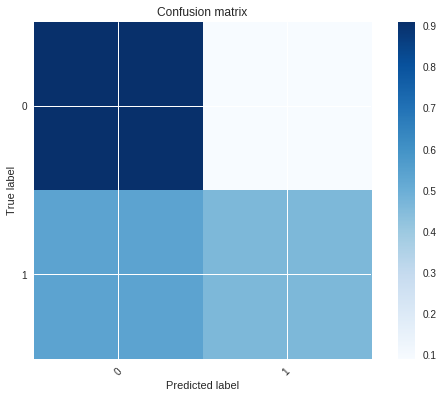

precision recall fscore support
(0.7526369046758739, 0.7575528700906344, 0.741220855920739, None) ABCMeta {'n_estimators': 30}


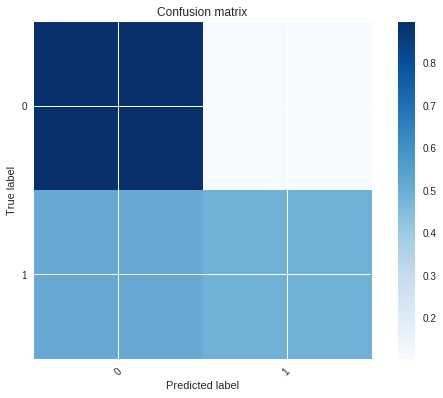

precision recall fscore support
(0.7505998175172244, 0.75730110775428, 0.7441447222333138, None) type {'penalty': 'l2', 'solver': 'sag'}


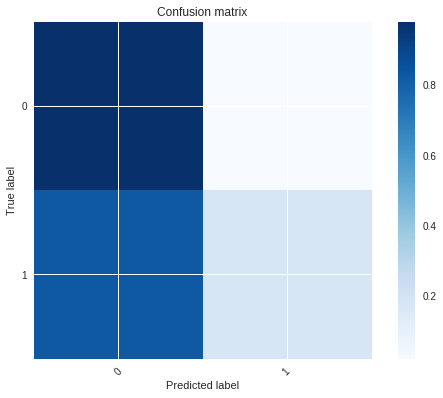

precision recall fscore support
(0.7348871132937774, 0.7041792547834844, 0.6334275176730388, None) ABCMeta {'n_neighbors': 5}


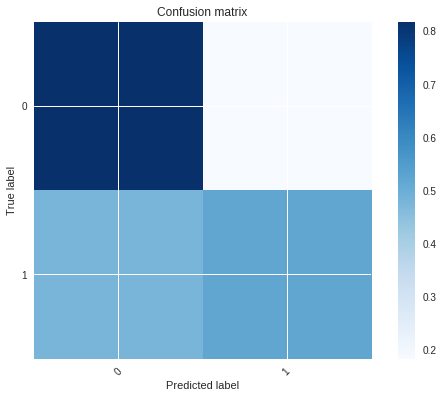

precision recall fscore support
(0.7089049549637411, 0.7162638469284995, 0.7111974573947104, None) ABCMeta {'criterion': 'gini'}


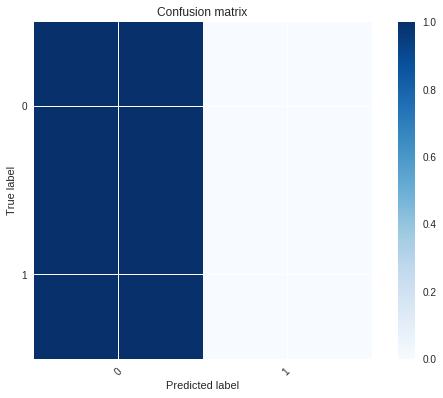

precision recall fscore support
(0.7754558356860746, 0.6593655589123867, 0.524534316780419, None) ABCMeta {'C': 10, 'kernel': 'rbf'}


In [40]:
#accs = []
for i,clf in enumerate(classifiers):
  precision_recall_fscore = []
  precision_recall_fscore = clf.test_and_plot(tst_vecs[i],tst_labels,class_num=2)
  print ('precision recall fscore support')
  print(precision_recall_fscore ,clf.classifier.__class__.__name__,clf.params)
  
  #precision_recall_fscore = clf.test_eval(tst_vecs[i],tst_labels,class_num=2)
  #print(precision_recall_fscore)
  #accs.append(acc)
  
#accs